In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Pima Indian Dataset 을 바탕으로 한국 건강검진 결과를 통해 당뇨를 예측하는 모델 만들어보기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,accuracy_score,auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.utils import np_utils
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Conv2D,MaxPooling2D, Flatten
df = pd.read_csv("../input/pima-diabetes-dataset/Diabetes.csv")

In [ ]:
print(df.columns.tolist())

# 결측치 처리 후 탐색적 데이터 분석

일단 학습에 용이하게, 모든 결측치를 중간값으로 바꿔준 뒤에 탐색적 데이터 분석에 들어가겠습니다.

In [ ]:
title_mapping = {'YES':1,'NO':0}
df[' Class variable']=df[' Class variable'].map(title_mapping)

In [ ]:
#0처리

z=(df == 0).sum(axis=0)
z=pd.DataFrame(z)
z.columns=['Zeros Count']
z.drop(' Class variable',inplace=True)
z.plot(kind='bar',stacked=True, figsize=(10,5),grid=True)

In [ ]:
col=['n_pregnant','glucose_conc','bp','skin_len','insulin','bmi','pedigree_fun','age','Output']
df.columns=col
df.head()

In [ ]:
#0 제거 후 nan 으로 변환
col=['glucose_conc','bp','insulin','bmi','skin_len']
for i in col:
    df[i].replace(0, np.nan, inplace= True)

In [ ]:
#결과확인
df.isnull().sum()

In [ ]:
def median_target(var):   
    temp = df[df[var].notnull()]
    temp = temp[[var, 'Output']].groupby(['Output'])[[var]].median().reset_index()
    return temp

In [ ]:
median_target('insulin')

In [ ]:
median_target('glucose_conc')

In [ ]:
median_target('skin_len')

In [ ]:
median_target('bp')

In [ ]:
median_target('bmi')

In [ ]:
#중간값으로 NaN 채워넣기
df.loc[(df['Output'] == 0 ) & (df['insulin'].isnull()), 'insulin'] = 102.5
df.loc[(df['Output'] == 1 ) & (df['insulin'].isnull()), 'insulin'] = 169.5
df.loc[(df['Output'] == 0 ) & (df['glucose_conc'].isnull()), 'glucose_conc'] = 107
df.loc[(df['Output'] == 1 ) & (df['glucose_conc'].isnull()), 'glucose_conc'] = 140
df.loc[(df['Output'] == 0 ) & (df['skin_len'].isnull()), 'skin_len'] = 27
df.loc[(df['Output'] == 1 ) & (df['skin_len'].isnull()), 'skin_len'] = 32
df.loc[(df['Output'] == 0 ) & (df['bp'].isnull()), 'bp'] = 70
df.loc[(df['Output'] == 1 ) & (df['bp'].isnull()), 'bp'] = 74.5
df.loc[(df['Output'] == 0 ) & (df['bmi'].isnull()), 'bmi'] = 30.1
df.loc[(df['Output'] == 1 ) & (df['bmi'].isnull()), 'bmi'] = 34.3

In [ ]:
#아웃라이어를 찾기 위한 박스플롯
plt.style.use('ggplot') # Using ggplot2 style visuals 

f, ax = plt.subplots(figsize=(11, 15))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-.05, 200))
plt.ylabel('Variables')
plt.title("Overview Data Set")
ax = sns.boxplot(data = df, 
  orient = 'h', 
  palette = 'Set2')

In [ ]:
#중간값을 활용한 아웃라이어 제거
sns.boxplot(df.n_pregnant)

df['n_pregnant'].value_counts()

In [ ]:
median_target('n_pregnant')

In [ ]:
#인위조정 : 임신횟수
df.loc[(df['Output'] == 0 ) & (df['n_pregnant']>13), 'n_pregnant'] = 2
df.loc[(df['Output'] == 1 ) & (df['n_pregnant']>13), 'n_pregnant'] = 4

In [ ]:
#확인사살
df['n_pregnant'].value_counts()

In [ ]:
#혈압. 이하 모든 변수에 대해서 반복하기 때문에 큰 설명은 하지 않겠습니다.
sns.boxplot(df.bp)

In [ ]:
median_target('bp')

In [ ]:
df.loc[(df['Output'] == 0 ) & (df['bp']<40), 'bp'] = 70
df.loc[(df['Output'] == 1 ) & (df['bp']<40), 'bp'] = 74.5

In [ ]:
df.loc[(df['Output'] == 0 ) & (df['bp']>103), 'bp'] = 70
df.loc[(df['Output'] == 1 ) & (df['bp']>103), 'bp'] = 74.5

In [ ]:
sns.boxplot(df.bp)

In [ ]:
sns.boxplot(df.skin_len)

In [ ]:
median_target('skin_len')

In [ ]:
df.loc[(df['Output'] == 0 ) & (df['skin_len']>38), 'skin_len'] = 27
df.loc[(df['Output'] == 1 ) & (df['skin_len']>38), 'skin_len'] = 32
df.loc[(df['Output'] == 0 ) & (df['skin_len']<20), 'skin_len'] = 27
df.loc[(df['Output'] == 1 ) & (df['skin_len']<20), 'skin_len'] = 32

In [ ]:
sns.boxplot(df.skin_len)

In [ ]:
sns.boxplot(df.bmi)

In [ ]:
median_target('bmi')

In [ ]:
df.loc[(df['Output'] == 0 ) & (df['bmi']>48), 'bmi'] = 30.1
df.loc[(df['Output'] == 1 ) & (df['bmi']>48), 'bmi'] = 34.3

In [ ]:
sns.boxplot(df.bmi)

In [ ]:
sns.boxplot(df.pedigree_fun)

In [ ]:
median_target('pedigree_fun')

In [ ]:
df.loc[(df['Output'] == 0 ) & (df['pedigree_fun']>1), 'pedigree_fun'] = 0.336
df.loc[(df['Output'] == 1 ) & (df['pedigree_fun']>1), 'pedigree_fun'] = 0.449
sns.boxplot(df.pedigree_fun)

In [ ]:
median_target('age')

In [ ]:
df.loc[(df['Output'] == 0 ) & (df['age']>61), 'age'] = 27
df.loc[(df['Output'] == 1 ) & (df['age']>61), 'age'] = 36

In [ ]:
VarCorr = df.corr()
print(VarCorr)
sns.heatmap(VarCorr,xticklabels=VarCorr.columns,yticklabels=VarCorr.columns)

# 상관결과 분석

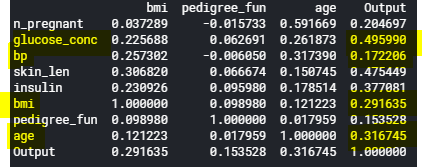

보시는 바와 같이 우리나라 건강 검진에서 받을 수 있는 데이터들이 가장 큰 상관계수를 보입니다.

혈당(glucose_conc) : 0.49
나이 (age) : 0.32
BMI (bmi) : 0.29
혈압(bp) : 0.25

순으로 높은 상관계수를 보입니다.

그러므로, 저는 대한민국 직장인 건강검진 데이터만으로도 당뇨병 발병확률을 예측하는게 충분히 가능할거라고 예상했습니다.





# 학습데이터 준비

학습 및 검증을 위해 테스트 셋과 학습용 셋을 분리했습니다.

In [ ]:
#테스트셋, 트레인셋 분리
X = df.drop(['n_pregnant','skin_len','insulin','pedigree_fun','Output'], 1)
y = df['Output']
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [ ]:
X.head(5)

# SVM (RBF 사용)

In [ ]:
std = StandardScaler()
x_train = std.fit_transform(x_train)
x_test = std.transform(x_test)

In [ ]:
model=SVC(kernel='rbf')
model.fit(x_train,y_train)

In [ ]:
y_pred=model.predict(x_test)

In [ ]:
accuracy_score(y_test,y_pred)

In [ ]:
confusion_matrix(y_test,y_pred)

In [ ]:
print(classification_report(y_test,y_pred))

# SVM (선형)

In [ ]:
model=SVC(kernel='linear')
model.fit(x_train,y_train)

In [ ]:
y_pred=model.predict(x_test)

In [ ]:
accuracy_score(y_test,y_pred)

In [ ]:
confusion_matrix(y_test,y_pred)

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
regressor=LogisticRegression()

In [ ]:
regressor.fit(x_train,y_train)

In [ ]:
y_pred=regressor.predict(x_test)

In [ ]:
accuracy_score(y_test,y_pred)

In [ ]:
confusion_matrix(y_test,y_pred)

# k-Nearest Neighbors

In [ ]:
clf = KNeighborsClassifier(n_neighbors=3) 
clf.fit(x_train,y_train)  
print(clf.score(x_test,y_test))

In [ ]:
print(classification_report(y_test,y_pred))

# Random Forest

In [ ]:
classifier=RandomForestClassifier()
classifier.fit(x_train,y_train)

In [ ]:
Y_pred=classifier.predict(x_test)
confusion_matrix(y_test,Y_pred)

In [ ]:
accuracy_score(y_test,Y_pred)

# Neural Net

In [ ]:
model = Sequential()
model.add(Dense(32,input_shape=(x_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dense(64,input_shape=(x_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dense(64,input_shape=(x_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dense(128,input_shape=(x_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dense(128,input_shape=(x_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dense(256,input_shape=(x_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dense(256,input_shape=(x_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

In [ ]:
print(model.summary())
model.compile(loss='sparse_categorical_crossentropy',
              optimizer="sgd",metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=10, epochs=50, verbose=1, validation_data=(x_test, y_test))
loss, accuracy = model.evaluate(x_test,y_test, verbose=0)
print("Loss : "+str(loss))
print("Accuracy :"+str(accuracy*100.0))

# 결론

일단 2020.04.22 Run3 기준 (이 글 업로드 시점 런)으로는 각 기법별 점수는 다음과 같습니다.
SVM(RBF 사용) : 78%
SVM(선형) : 79%
k-최근접 이웃 : 78%
랜덤 포레스트 : 77%
인공신경망 : 77%

1. 모든 방법들이 80%정도 이내의 정확도를 보입니다.
SVM(RBF 사용) 과 Random Forest 가 77~80 사이로 가장 안정적인 명중률을 보입니다.


2. 인공신경망은 만능이 아닙니다.
실행 시간은 가장 긴데, kNN이나 SVM 등 머신러닝 방법론들과 그렇게 유의미한 명중률 차이를 보이지 않습니다 (2~3% 엎치락 뒤치락하는정도)


3. 정확도가 생각보다 높게 나옵니다
인슐린, 살갗 두께, 임신 횟수, 당뇨 함수 변수들의 나머지 반을 쳐냈음에도 불구하고, 78~80% 정도의 정확도를 보이고 있습니다.

